In [1]:
import pandas as pd
import os
import numpy as np
import time
import random

In [17]:
mlp.get_params()

{'C': 1.0,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'fit_intercept': True,
 'loss': 'epsilon_insensitive',
 'max_iter': 1000,
 'n_iter_no_change': 10,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [3]:
import tensorflow as tf
import keras
from keras import layers
import pickle

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Testing model 1

In [4]:
threshold = 20
movenum_max = 60 * 2

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
from keras import models
from keras import optimizers

model = models.Sequential()

model.add(layers.Conv2D(256, (2, 2), padding = 'same', activation='relu', input_shape=(3, movenum_max, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D(padding = (2, 2), data_format = 'channels_last'))

model.add(layers.Conv2D(128, (3, 3), padding = 'same', activation='relu', input_shape=(3, movenum_max, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D(padding = (3, 3), data_format = 'channels_last'))

model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(3, movenum_max, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D(padding = (3, 3), data_format = 'channels_last'))

model.add(layers.Conv2D(64, (5, 5), padding = 'same', activation='relu', input_shape=(3, movenum_max, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D(padding = (3, 3), data_format = 'channels_last'))

model.add(layers.Conv2D(32, (5, 5), padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(1))

model.compile(optimizer= optimizers.Adam(),
              loss=tf.keras.losses.mse)

In [7]:
df_y_test = pd.DataFrame()
test_tb_list = []
histories = []

In [9]:
import gc

df_y_test = pd.DataFrame()
test_tb_list = []
histories = []

for i in range(0, 27):
    dir = "/kaggle/input/split-new/split_new_" + str(i) + ".pkl"
    df_dir = "/kaggle/input/split-new/split_dfy_" + str(i) + ".pkl"
    file = open(dir ,'rb')
    tb_list = pickle.load(file)
    file.close()

    file = open(df_dir,'rb')
    df_output = pickle.load(file)
    file.close()
    df_output['avg_elo'] = (df_output['WhiteElo'] + df_output['BlackElo']) / 2
    
    X_train, X_test, y_train, y_test = train_test_split(tb_list, df_output[['avg_elo']], test_size=0.02, random_state= 42)
    del tb_list
    gc.collect()

    for test_sample in X_test:
        test_tb_list.append(test_sample)
    if(i == 0):
        df_y_test = y_test
    else:
        df_y_test = pd.concat([df_y_test, y_test], axis = 0)
    
    X_train = np.array(X_train)
    X_train = tf.reshape(X_train, shape = [len(X_train), 3, movenum_max, 1])

    history = model.fit(X_train, y_train, epochs= 10)
    histories.append(history.history)
    del X_train, X_test, y_train, y_test, history, df_output
    gc.collect()

Epoch 1/10
1090/1090 [==============================] - 23s 9ms/step - loss: 173878.2344
Epoch 2/10
1090/1090 [==============================] - 9s 8ms/step - loss: 122617.3047
Epoch 3/10
1090/1090 [==============================] - 10s 9ms/step - loss: 121112.5859
Epoch 4/10
1090/1090 [==============================] - 9s 8ms/step - loss: 117131.7188
Epoch 5/10
1090/1090 [==============================] - 9s 9ms/step - loss: 113116.3125
Epoch 6/10
1090/1090 [==============================] - 10s 9ms/step - loss: 112981.2812
Epoch 7/10
1090/1090 [==============================] - 9s 9ms/step - loss: 110327.6641
Epoch 8/10
1090/1090 [==============================] - 9s 9ms/step - loss: 109830.1719
Epoch 9/10
1090/1090 [==============================] - 10s 9ms/step - loss: 107055.9375
Epoch 10/10
1090/1090 [==============================] - 10s 9ms/step - loss: 105859.5703
Epoch 1/10
1090/1090 [==============================] - 10s 9ms/step - loss: 103603.8594
Epoch 2/10
1090/1090 [===

In [11]:
with open('/kaggle/working/model_personal.pkl', 'wb') as handle:
    pickle.dump(model, handle)

In [22]:
x_test_tf = np.asarray(test_tb_list)
x_test_tf = tf.reshape(x_test_tf, shape = [len(df_y_test), 3, movenum_max, 1])
y_predict = model.predict(x_test_tf)

598/598 [==============================] - 2s 3ms/step


In [26]:
with open('/kaggle/working/x_test_tf.pkl', 'wb') as handle:
    pickle.dump(x_test_tf, handle)
df_y_test.to_csv('/kaggle/working/df_y_test.csv', index = False)

In [29]:
score = model.evaluate(x_test_tf,df_y_test)
print(score)

598/598 [==============================] - 3s 4ms/step - loss: 100880.3672
100880.3671875


In [32]:
test_y = pd.DataFrame(y_predict)
test_y.columns = ['avg_elo_pred']
test_y = test_y.reset_index()
test_y = pd.concat([test_y, df_y_test.reset_index()], axis = 1)

In [37]:
test_y = test_y[['avg_elo_pred', 'avg_elo']]
test_y['over_predict'] = 0
test_y.loc[test_y.avg_elo_pred - test_y.avg_elo >= 100, 'over_predict'] = 1
test_y.loc[test_y.avg_elo_pred - test_y.avg_elo <= -100, 'over_predict'] = -1

In [41]:
test_y = test_y[['avg_elo_pred', 'avg_elo']]
test_y['over_predict'] = 0
test_y.loc[test_y.avg_elo_pred - test_y.avg_elo >= 100, 'over_predict'] = 1
test_y.loc[test_y.avg_elo_pred - test_y.avg_elo <= -100, 'over_predict'] = -1

In [49]:
test_y.to_csv("/kaggle/working/model_personal_result.csv", index = False)

## Testing Model 2 : VGG16

In [10]:
from keras import models
from keras.layers import * 
from keras import optimizers
from keras import applications

img_input = layers.Input(shape=(3,movenum_max,1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])
img_conc2 = layers.Concatenate(axis = -3)([img_conc, img_conc, img_conc, img_conc, img_conc, 
                                   img_conc, img_conc, img_conc, img_conc, img_conc, img_conc])
base_model = applications.VGG16(include_top=False, weights = None,
                                pooling='avg', input_shape = (33, movenum_max, 3))([img_conc2])
final = layers.Dense(1)(base_model)
model = models.Model(inputs = img_input, outputs = final)
model.compile(optimizer= optimizers.Adam(),
              loss=tf.keras.losses.mse)

In [13]:
df_y_test = pd.DataFrame()
test_tb_list = []
histories = []

In [14]:
import gc

df_y_test = pd.DataFrame()
test_tb_list = []
histories = []

for i in range(0, 27):
    dir = "/kaggle/input/split-new/split_new_" + str(i) + ".pkl"
    df_dir = "/kaggle/input/split-new/split_dfy_" + str(i) + ".pkl"
    file = open(dir ,'rb')
    tb_list = pickle.load(file)
    file.close()

    file = open(df_dir,'rb')
    df_output = pickle.load(file)
    file.close()
    df_output['avg_elo'] = (df_output['WhiteElo'] + df_output['BlackElo']) / 2
    
    X_train, X_test, y_train, y_test = train_test_split(tb_list, df_output[['avg_elo']], test_size=0.02, random_state= 42)
    del tb_list
    gc.collect()

    for test_sample in X_test:
        test_tb_list.append(test_sample)
    if(i == 0):
        df_y_test = y_test
    else:
        df_y_test = pd.concat([df_y_test, y_test], axis = 0)
    
    X_train = np.array(X_train)
    X_train = tf.reshape(X_train, shape = [len(X_train), 3, movenum_max, 1])

    history = model.fit(X_train, y_train, epochs= 10)
    histories.append(history.history)
    del X_train, X_test, y_train, y_test, history, df_output
    gc.collect()

Epoch 1/10
1090/1090 [==============================] - 62s 48ms/step - loss: 224484.5625
Epoch 2/10
1090/1090 [==============================] - 52s 48ms/step - loss: 128268.0938
Epoch 3/10
1090/1090 [==============================] - 52s 47ms/step - loss: 125629.9531
Epoch 4/10
1090/1090 [==============================] - 52s 47ms/step - loss: 119592.4609
Epoch 5/10
1090/1090 [==============================] - 52s 47ms/step - loss: 117716.3359
Epoch 6/10
1090/1090 [==============================] - 52s 47ms/step - loss: 114179.5781
Epoch 7/10
1090/1090 [==============================] - 51s 47ms/step - loss: 112238.9219
Epoch 8/10
1090/1090 [==============================] - 51s 47ms/step - loss: 111058.8828
Epoch 9/10
1090/1090 [==============================] - 51s 47ms/step - loss: 106815.4844
Epoch 10/10
1090/1090 [==============================] - 51s 47ms/step - loss: 106710.2422
Epoch 1/10
1090/1090 [==============================] - 53s 48ms/step - loss: 104263.4062
Epoch 2/1

In [16]:
with open('/kaggle/working/model_vgg16.pkl', 'wb') as handle:
    pickle.dump(model, handle)

In [23]:
x_test_tf = np.asarray(test_tb_list)
x_test_tf = tf.reshape(x_test_tf, shape = [len(df_y_test), 3, movenum_max, 1])
y_predict = model.predict(x_test_tf)

598/598 [==============================] - 8s 13ms/step


In [26]:
score = model.evaluate(x_test_tf,df_y_test)
print(score)

598/598 [==============================] - 8s 14ms/step - loss: 110574.3516
110574.3515625


In [28]:
test_y = pd.DataFrame(y_predict)
test_y.columns = ['avg_elo_pred']
test_y = test_y.reset_index()
test_y = pd.concat([test_y, df_y_test.reset_index()], axis = 1)

In [34]:
test_y

,index,avg_elo_pred,index,avg_elo
0,0,1080.403931,22875,1047.0
1,1,1529.918457,16801,1066.5
2,2,877.867859,25696,793.5
3,3,1184.772705,8193,948.0
4,4,1977.666748,18836,2257.0
...,...,...,...,...
19114,19114,1646.734741,82474,1721.0
19115,19115,2232.415283,90535,2062.5
19116,19116,1588.268677,96946,1666.5
19117,19117,1064.128906,76095,1164.5


In [39]:
test_y = test_y[['avg_elo_pred', 'avg_elo']]
test_y['over_predict'] = 0
test_y.loc[test_y.avg_elo_pred - test_y.avg_elo >= 100, 'over_predict'] = 1
test_y.loc[test_y.avg_elo_pred - test_y.avg_elo <= -100, 'over_predict'] = -1

In [43]:
test_y.to_csv("/kaggle/working/model_vgg16_result.csv", index = False)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


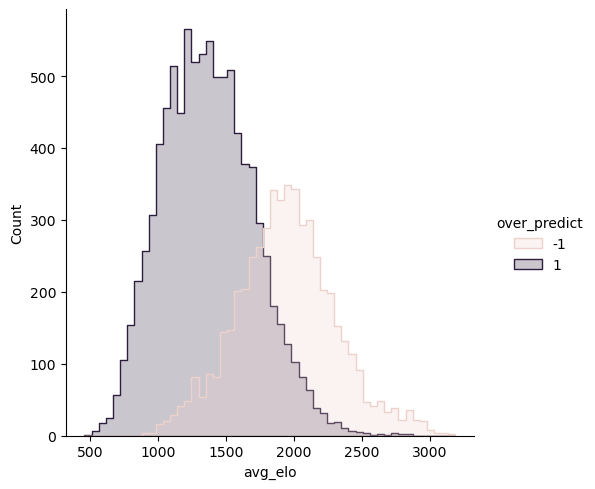

In [47]:
import seaborn as sns
sns.displot(test_y[test_y.over_predict != 0], x="avg_elo", hue="over_predict", element="step")

(500.0, 3500.0)

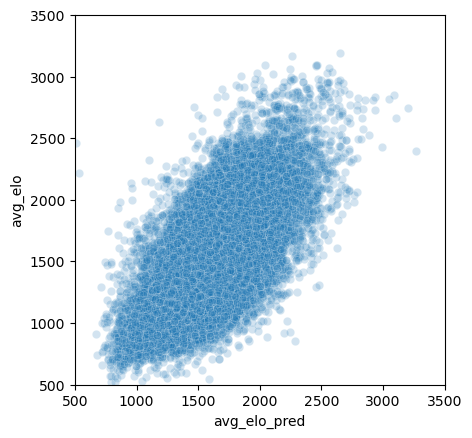

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.scatterplot(data = test_y, x = 'avg_elo_pred', y = 'avg_elo', alpha = 0.2, ax = ax)
ax.set_box_aspect(1)
ax.set_xlim(500, 3500)
ax.set_ylim(500, 3500)

## Passive Aggressive Regressor

In [16]:
from sklearn.linear_model import PassiveAggressiveRegressor
mlp = PassiveAggressiveRegressor(n_iter_no_change = 10, random_state = 42)

In [19]:
import gc

df_y_test = pd.DataFrame()
test_tb_list = []
histories = []

for i in range(0, 27):
    dir = "/kaggle/input/split-new/split_new_" + str(i) + ".pkl"
    df_dir = "/kaggle/input/split-new/split_dfy_" + str(i) + ".pkl"
    file = open(dir ,'rb')
    tb_list = pickle.load(file)
    file.close()

    file = open(df_dir,'rb')
    df_output = pickle.load(file)
    file.close()
    df_output['avg_elo'] = (df_output['WhiteElo'] + df_output['BlackElo']) / 2
    for i in range(0, len(tb_list)):
        tb_list[i] = np.asarray(tb_list[i])
        tb_list[i] = tb_list[i].flatten()
    X_train, X_test, y_train, y_test = train_test_split(tb_list, df_output[['avg_elo']], test_size=0.02, random_state= 42)
    del tb_list
    gc.collect()

    for test_sample in X_test:
        test_tb_list.append(test_sample)
    if(i == 0):
        df_y_test = y_test
    else:
        df_y_test = pd.concat([df_y_test, y_test], axis = 0)
    
    X_train = np.array(X_train)

    mlp.partial_fit(X_train, y_train)
    del X_train, X_test, y_train, y_test, df_output
    if(i == 1):
        break
    gc.collect()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [20]:
with open('/kaggle/working/model_PAR.pkl', 'wb') as handle:
    pickle.dump(model, handle)

NameError: name 'model' is not defined

In [21]:
len(test_tb_list)

19119

In [22]:
len(df_y_test)

19119

In [24]:
y_predict = mlp.predict(test_tb_list)
test_y = pd.DataFrame(y_predict)
test_y.columns = ['avg_elo_pred']
test_y = test_y.reset_index()
test_y = pd.concat([test_y, df_y_test.reset_index()], axis = 1)

In [25]:
test_y = test_y[['avg_elo_pred', 'avg_elo']]
test_y['over_predict'] = 0
test_y.loc[test_y.avg_elo_pred - test_y.avg_elo >= 100, 'over_predict'] = 1
test_y.loc[test_y.avg_elo_pred - test_y.avg_elo <= -100, 'over_predict'] = -1

In [26]:
mlp.score(test_tb_list, df_y_test)

0.259758733936273

In [28]:
test_y.to_csv("/kaggle/working/model_PAR.csv", index = False)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


NameError: name 'plt' is not defined

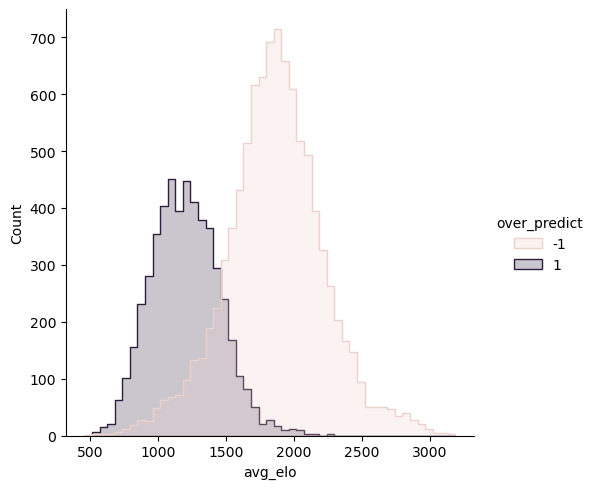

In [29]:
import seaborn as sns
sns.displot(test_y[test_y.over_predict != 0], x="avg_elo", hue="over_predict", element="step")
plt.savefig("/kaggle/working/linear_overpredict.png")

(500.0, 3500.0)

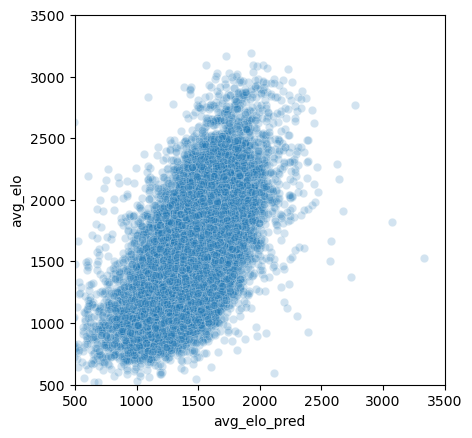

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.scatterplot(data = test_y, x = 'avg_elo_pred', y = 'avg_elo', alpha = 0.2, ax = ax)
ax.set_box_aspect(1)
ax.set_xlim(500, 3500)
ax.set_ylim(500, 3500)